# TP3 - Data Augmentation

Dans cette séance nous nous sommes concentré sur les avancées en *architecture* pour les réseaux de neurones. Dans ce TP on décide de compléter cela en s'intéressant sur les avancées dans la **data augmentation** : autrement dit, nous allons travailler sur les données, et utiliser le cours pour améliorer le réseau lui-même.

Nous travaillerons avec le dataset [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html). Il correspond à un dataset de 60 000 images en couleurs de taille (32, 32) répartie dans 10 classes. Le tests contient exactement 1000 images de chaque catégories. Commençons par importer les données.

In [80]:
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import keras
import keras_cv

import matplotlib.pyplot as plt

dataset = tfds.load("cifar10", as_supervised=True)
dataset_train, dataset_test = dataset["train"], dataset["test"]

**Question** : Quel est le type de la variable *dataset_train* ?

In [81]:
type(dataset_train)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

Nous allons travailler avec des [tensorflow dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) et non un dataframe pandas classique. Nous allons donc devoir travailler avec les méthodes suivantes: 
* `map`: applique une fonction à l'ensemble du dataset, tenseur par tenseur
* `batch`: groupe les lignes consécutives en batch de taille *batch_size*
* `shuffle`: mélange aléatoirement les observations du dataset
* `take`: crée un dataset d'au plus le nombre d'observations indiqué

## Preprocessing des données

Commençons par transformer le dataset pour simplifier notre utilisation. Nous en profitons au passage pour changer la taille des images de (32, 32, 3) à (64, 64, 3)

In [82]:
image_size = (64, 64)
n_class = 102
batch_size = 526

def process_dataset(image, label):
    image = tf.image.resize(image, image_size)
    image = tf.cast(image, tf.float32)
    label = tf.one_hot(label, n_class)
    return {"images": image, "labels": label}

dataset_train = dataset_train.map(process_dataset).batch(batch_size)

Notons que nous avons *One-Hot-Encodé* les labels. C'est fait implicitement par la fonction de perte [SparseCategoricalCrossentropy](https://keras.io/api/losses/probabilistic_losses/#sparsecategoricalcrossentropy-class), mais puisque nous l'avons déjà fait, nous utiliserons la fonction [CategoricalCrossentropy](https://keras.io/api/losses/probabilistic_losses/#categoricalcrossentropy-class). Ce choix est justifié par les techniques que nous allons employé par la suite.

In [83]:
def visualize_dataset(dataset, title, figsize=(6, 6)):
    plt.figure(figsize=figsize)

    for index, sample in enumerate(iter(dataset.take(9))):
        images = sample["images"]
        plt.subplot(3, 3, index + 1)
        plt.imshow(images[0].numpy().astype("uint8"))
        plt.axis("off")
    
    plt.suptitle(title, fontsize=14)
    plt.show()

2024-05-05 16:23:27.063527: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-05-05 16:23:27.074303: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


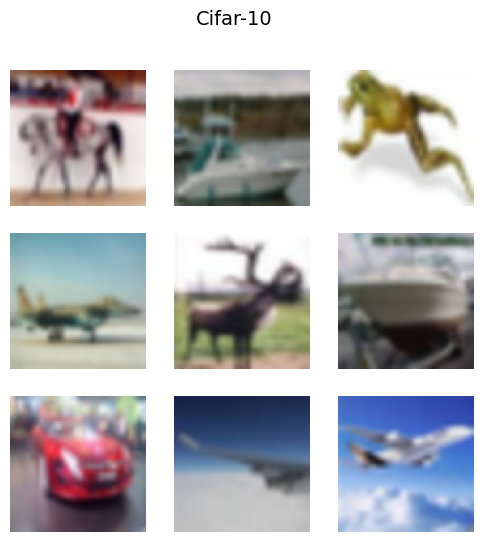

In [84]:
visualize_dataset(dataset_train, "Cifar-10")

On peut se convaincre de l'intérêt de changer la taille des images de (32, 32) à (64, 64) en appréciant le changement de qualité des images si on n'applique pas de changmenet de taille.

## Augmentations classique

Pour complexifier un peu la tâche de classification et éviter un sur-apprentissage, il est conseillé d'appliquer des transformations sur les images. Observons ce fonctionnement avec la couche [RandomFlip](https://keras.io/api/layers/preprocessing_layers/image_augmentation/random_flip/)

2024-05-05 15:57:10.528321: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-05-05 15:57:10.557046: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


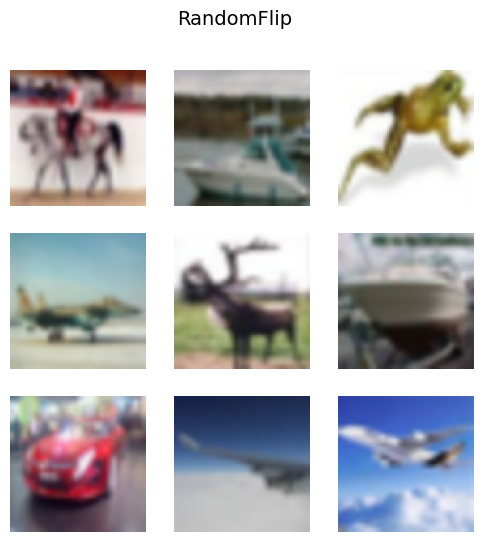

In [70]:
augmentation = keras_cv.layers.Augmenter([keras_cv.layers.RandomFlip()])
dataset_augmentation = dataset_train.map(lambda samples: augmentation(samples))
visualize_dataset(dataset_augmentation, "RandomFlip")

**Consigne** : Appliquer au dataset train une pipeline d'augmentation contenant [RandomFlip](https://keras.io/api/layers/preprocessing_layers/image_augmentation/random_flip/) et [RandomRotation](https://keras.io/api/layers/preprocessing_layers/image_augmentation/random_rotation/), puis le visualiser.

2024-05-05 15:57:11.937856: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-05-05 15:57:11.954703: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


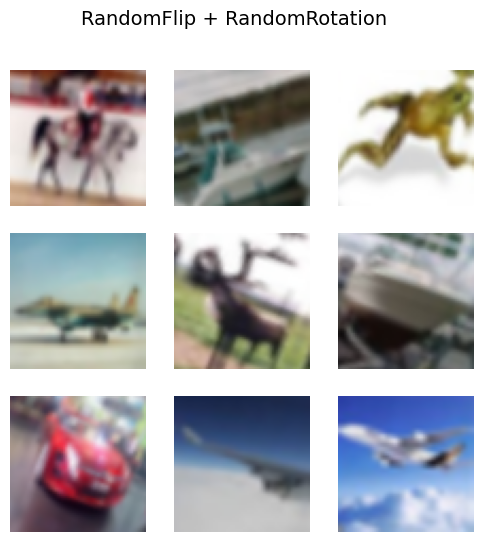

In [71]:
augmentation = keras_cv.layers.Augmenter([keras_cv.layers.RandomFlip(), keras_cv.layers.RandomRotation(factor=(-0.1, 0.1))])

dataset_augmentation = dataset_train.map(lambda samples: augmentation(samples))
visualize_dataset(dataset_augmentation, "RandomFlip + RandomRotation")

D'autres manières d'augmenter les images de la même manière peuvent être trouvée dans la [documentation Keras](https://keras.io/api/layers/preprocessing_layers/image_augmentation/).

## Augmentations moderne

On commence par s'intéresser à la méthode [MixUp](https://arxiv.org/abs/1710.09412) proposée en 2017. Son objectif est de créer de nouvelles images en mélangeant linéairement deux images, mais aussi les classes ! Cela force le modèle à apprendre des relations *linéaire* entre des parties de l'image et sa classe. On obtient un modèle plus robuste et qui généralise mieux.

**Consigne** : Appliquer uniquement l'augmentation [MixUp](https://keras.io/api/keras_cv/layers/augmentation/mix_up/).

2024-05-05 15:57:12.919582: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-05-05 15:57:12.951766: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


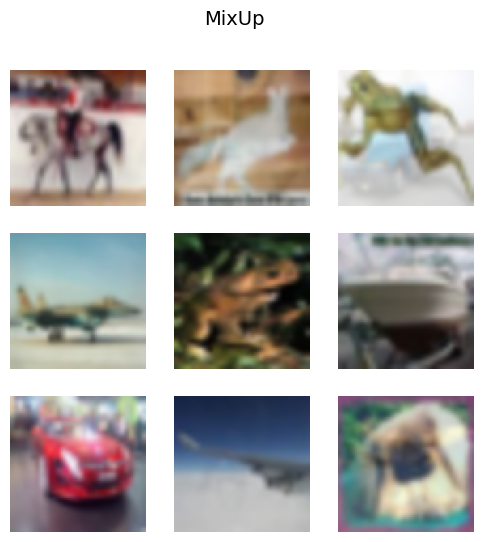

In [73]:
mix_up = keras_cv.layers.Augmenter([keras_cv.layers.MixUp()])

dataset_cutmix = dataset_train.map(lambda samples: mix_up(samples))
visualize_dataset(dataset_cutmix, "MixUp")

Deux ans plus tard, [CutMix](https://arxiv.org/abs/1905.04899) est proposée, dans la même idée que MixUp.

**Consigne** : Appliquer uniquement l'augmentation [CutMix](https://keras.io/api/keras_cv/layers/augmentation/cut_mix/) puis commenter.

2024-05-05 15:57:12.451398: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-05-05 15:57:12.465209: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


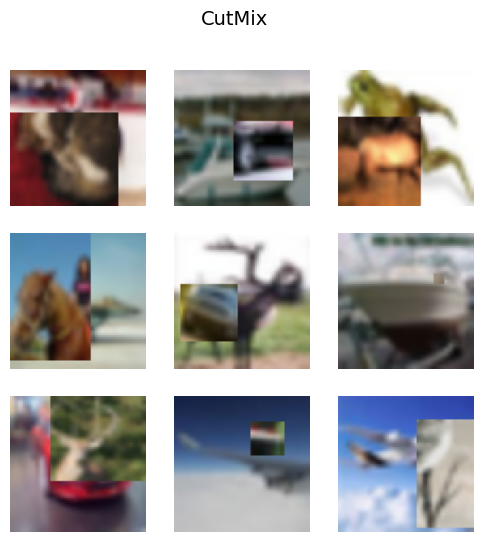

In [72]:
cut_mix = keras_cv.layers.Augmenter([keras_cv.layers.CutMix()])

dataset_cutmix = dataset_train.map(lambda samples: cut_mix(samples))
visualize_dataset(dataset_cutmix, "CutMix")

On construit à nouveau une nouvelle image mais on ne mélange que les labels. L'image est elle construite en superposant les images de manière aléatoire ! Nous sommes à nouveau censé obtenir une meilleure robustesse et généralisation de la part du réseau.

On souhaite vérifier ces promesses. Pour le faire, on se propose de tester les deux dernières techniques indépendamment contre un modèle entraîné sans augmentation. Mais avant, nous devons régler quelques détails.

## Préparation des données

Jusqu'ici nous avons travaillé directement avec les données brutes avec chaque valeurs entre 0 et 255. Pour que le réseau se comporte mieux, il faut au moins placer les valeurs entre 0 et 1.

**Consigne** : Modifier la fonction `process_dataset` pour que les valeurs soient entre 0 et 1. On utilisera la fonction `tf.divide` qui prend en paramètre $x$ et $y$ et divise $x$ par $y$ élément par élément.

In [85]:
def process_dataset(image, label):
    image = tf.image.resize(image, image_size)
    image = tf.cast(image, tf.float32)
    image = tf.divide(image, 255)
    label = tf.one_hot(label, n_class)
    return {"images": image, "labels": label}

**Consigne** : Définir une fonction `get_dataset` qui prend en paramètre *augmentation*, valant par défaut *None*, qui correspond aux augmentations que l'on souhaite faire. Cette fonction renvoie les datasets de train et de test à partir des datasets initiaux *dataset_train* et *dataset_test* où l'on aura appliqué les transformations suivantes :
1. Pour l'entraînement, mélanger les données
2. Pour les deux, application de la fonction `process_dataset`
3. Pour les deux, création des batch
4. Pour l'entraînement, application de l'augmentation si elle ne vaut pas *None*


In [ ]:
def get_dataset(augmentation=None):

    def augment_dataset(image, label):
        output = augmentation({"images": image, "labels": label})
        return output['images'], output['labels']

    if augmentation is None:
        train = dataset_train.shuffle(10*batch_size).map(process_dataset).cache().batch(batch_size)
        test = dataset_test.map(process_dataset).cache().batch(batch_size)
    else:
        train = dataset_train.shuffle(10*batch_size).map(process_dataset).cache().batch(batch_size).map(augment_dataset)
        test = dataset_test.map(process_dataset).cache().batch(batch_size) 
    return train, test

Puisque nous allons entraîner plusieurs fois le même modèle, et que seules les courbes d'apprentissages sont importantes, nous allons construire une fonction pour entraîner et renvoyer les courbes d'apprentissages.

Dans la définition d'un modèle, une bonne pratique est d'utiliser au début la couche `keras.layers.Input`pour renseigner la taille de l'input que recevra le modèle. On utilisera l'optimizer [AdamW](https://keras.io/api/optimizers/adamw/) ainsi que la fonction de perte [CategoricalCrossEntropy](https://keras.io/api/losses/probabilistic_losses/#categoricalcrossentropy-class). 

Nous allons tester les techniques CutMix et MixUp qui modifie les labels : nous n'avons plus 0/1 pour chaque classe mais des proportions. Dans ce cadre, mais pas seulement, il est recommandé d'utiliser le *label smoothing* initialement introduit dans l'[article](https://arxiv.org/pdf/1512.00567) qui améliore l'architecture Inception. Son objectif est de réduire le sur-apprentissage en rendant le modèle moins confiant dans ses prédictions via une modification des labels. Par exemple, pour une classification binaire :
* Observation $i$ : $y_i = [0, 0, 1]$ devient $y_i = [0.1, 0.1, 9.0]$ si l'on demande un label smoothing de 0.1.

**Consigne** : Définir une fonction `fit_model` qui prend en paramètre *augmentation*, valant par défaut *None*, qui correspond aux augmentations que l'on souhaite faire ainsi que *n_epochs* qui correspond au nombre d'époques d'entraînement. Cette fonction initialise, compile puis entraîne un modèle. Elle renverra le dataframe de l'historique d'entraînement. La fonction exploite la fonction `get_dataset` pour charger les datasets pré-traité.

In [ ]:
def fit_model(n_epochs, augmentation=None):
    model = keras.models.Sequential([
        keras.layers.Input(shape=(64, 64, 3)),

        keras.layers.Conv2D(filters=64, kernel_size=7, padding="same"),
        keras.layers.Conv2D(filters=64, kernel_size=7, padding="same", activation="relu"),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(pool_size=2),

        keras.layers.Conv2D(filters=32, kernel_size=5, padding="same"),
        keras.layers.Conv2D(filters=32, kernel_size=5, padding="same", activation="relu"),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(pool_size=2),

        keras.layers.Flatten(),
        keras.layers.Dense(units=64, kernel_initializer="he_normal", activation="relu"),
        keras.layers.Dense(units=10, kernel_initializer="he_normal", activation="softmax")
    ])

    train, test = get_dataset(augmentation=augmentation)
    model.compile(optimizer=keras.optimizers.AdamW(), loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.1), metrics=["accuracy"])
    history = model.fit(train, epochs=n_epochs, validation_data=test)
    return pd.DataFrame(history.history)

**Consigne** : Réaliser l'étude.